In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Divya_2ndSem/Practice/DL Practice

/content/drive/MyDrive/Divya_2ndSem/Practice/DL Practice


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### Load Data

In [ ]:
data = pd.read_csv('mnist_train.csv')
# data.head(3), data.shape
# X = data.iloc[:, 1:].values
# y = data.iloc[:, :1].values
# X, y

In [ ]:
data = np.array(data)
X = data[:,1:]
y = data[:,0]

In [ ]:
X.shape, y.shape

((60000, 784), (60000,))

#### Transform to 4D

In [ ]:
X = X.reshape(X.shape[0], 1, 28, 28)
X.shape # no. of samples, channels, width, height

(60000, 1, 28, 28)

#### Steps to use Data in Pytorch

In [ ]:
# Step1: Convert to pytorch tensor
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)

# Step2: perform train test split
train_data, test_data, train_label, test_label = train_test_split(X_t, y_t, test_size=0.2, random_state=42)
train_data = train_data/torch.max(train_data)
test_data = test_data/torch.max(test_data)

# Convert to pytorch dataset
X_train = TensorDataset(train_data, train_label)
X_test = TensorDataset(test_data, test_label)

# Move data to dataloader objects
batchSize = 32
train_loader = DataLoader(X_train, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(X_test, batch_size=X_test.tensors[0].shape[0])

In [ ]:
for X,y in train_loader:
    break
X.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

#### Create Convolutional Neural Network

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 10, 5, 1, 1) # 5ip - channel, no. of kernels, kernel size, stride, padding
        # w, h after convolution = (((28 - 5) + (2 * 1)) / 1) + 1 = 26 and D = 10
        # w, h after max pooling = 26/2 = 13
        # 1 channel ---> 10 channels
        self.conv2 =  nn.Conv2d(10, 20, 5, 1, 1)
        # w, h after convolution = (((13 - 5) + (2 * 1)) / 1) + 1 = 11 and D = 10
        # w, h after max pooling = 11/2 =  np.floor(5.5) = 5
        # 10 channel ---> 20 channels
        # 20 kernels in conv layer before FC layer
        # dim of feature map (after conv + maxpool) --> 20 * 5 * 5
        # hence 20 feature map each of size (5 x 5)

        # Fully connected layer and output layer
        # self.fc = nn.Linear(5*5*20, 64)
        self.fc = nn.LazyLinear(64)
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # 2 --> stride
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        # x = x.view(-1, 5*5*20) # infer the first dimension (flatten)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.output(x)
        return x

#### Instance of the model

In [ ]:
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc): LazyLinear(in_features=0, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

#### Count the number of parameters in the model

In [ ]:
summary(model.cuda(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 64]          32,064
            Linear-4                   [-1, 10]             650
Total params: 37,994
Trainable params: 37,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.14
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


- Parameters in 1st layer
  - channel * filter_dim * output_dim(depth of feature map) + bias(no. of kernels)
  - 1 * 5*5 * 10 + 10 = 260
- Parameters in 2nd layer
  - channel * filter_dim * output_dim(depth of feature map) + bias(no. of kernels)
  - 10 * 5*5 * 20 + 20 = 5020
- Parameters in fully connected layer
  - no. of features * feature map * output feature + bias
  - 20 * 5*5 * 64 + 64 = 32064
- Parameters in o/p layer
  - 64 * 10 * 10 = 650
- Total parameters
  - 260 + 5,020 + 32,064 + 650 = 37,994

#### Training and testing the model

In [ ]:
learningRate = 0.01
momentum = 0.9
lossfc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=learningRate)

model.to(device)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=500, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
epochs = 250
losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []

for epoch in range(epochs):
    model.train()
    batchAcc = []
    batchLoss = []
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)  # Move to device
        ypred = model(X)
        loss = lossfc(ypred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batchLoss.append(loss.item())

        ypred = ypred.cpu()  # Move back to CPU
        y = y.cpu()

        acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
        batchAcc.append(acc)

    trainAcc.append(np.mean(batchAcc))
    losses[epoch] = np.mean(batchLoss)

    model.eval()
    X, y = next(iter(test_loader))
    X, y = X.to(device), y.to(device)
    with torch.no_grad():
        ypred = model(X)
        ypred = ypred.cpu()
        y = y.cpu()
        testAcc.append(100 * torch.mean((torch.argmax(ypred, dim=1) == y).float()))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss:.4f}')

Epoch 0/250, Loss: 0.0123
Epoch 10/250, Loss: 0.0083
Epoch 20/250, Loss: 0.0000
Epoch 30/250, Loss: 0.0000
Epoch 40/250, Loss: 0.0000
Epoch 50/250, Loss: 0.0000
Epoch 60/250, Loss: 0.0000
Epoch 70/250, Loss: 0.0000
Epoch 80/250, Loss: 0.0000
Epoch 90/250, Loss: 0.0000
Epoch 100/250, Loss: 0.0000
Epoch 110/250, Loss: 0.0000
Epoch 120/250, Loss: 0.0000
Epoch 130/250, Loss: 0.0000
Epoch 140/250, Loss: 0.0000
Epoch 150/250, Loss: 0.0000
Epoch 160/250, Loss: 0.0000
Epoch 170/250, Loss: 0.0000
Epoch 180/250, Loss: 0.0000
Epoch 190/250, Loss: 0.0000
Epoch 200/250, Loss: 0.0000
Epoch 210/250, Loss: 0.0000
Epoch 220/250, Loss: 0.0000
Epoch 230/250, Loss: 0.0000
Epoch 240/250, Loss: 0.0000


#### Visualizing the Loss and Accuracies

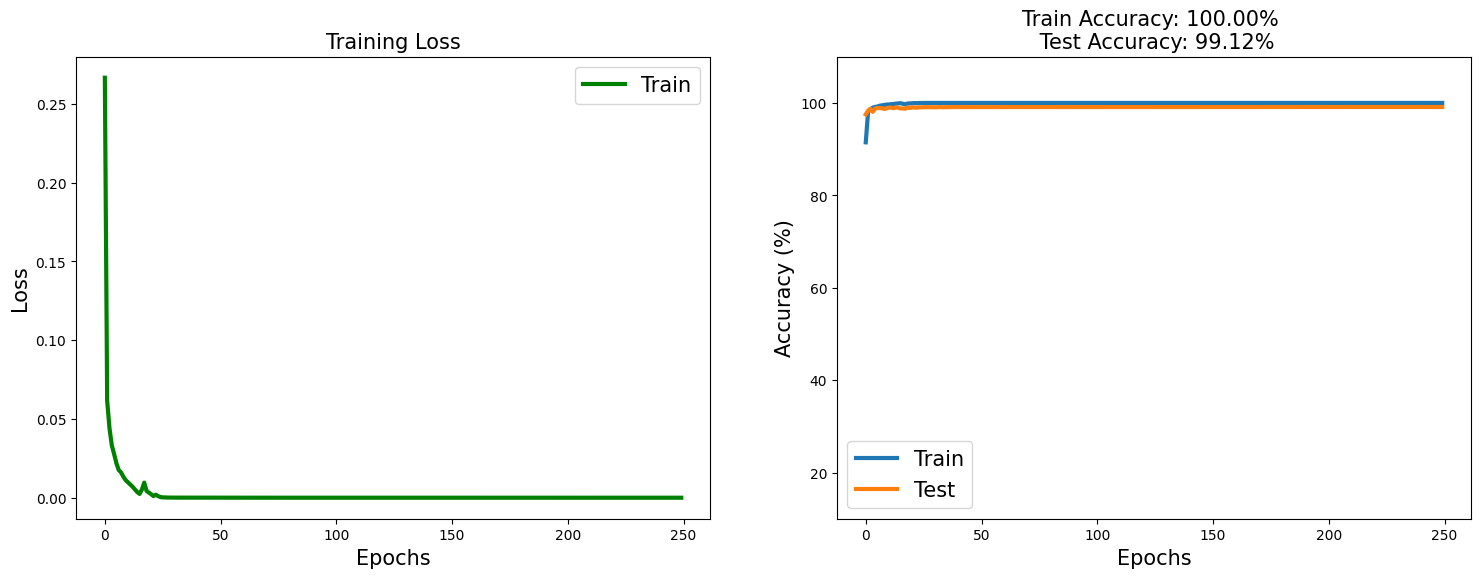

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()